In [242]:
import numpy as np
import pandas as pd
import random
import matplotlib.pyplot as plt
%matplotlib inline
from matplotlib.pylab import rcParams
rcParams['figure.figsize'] = 12, 10
from sklearn.preprocessing import scale
from sklearn import cross_validation
from sklearn.linear_model import Ridge, RidgeCV, Lasso, LassoCV, ElasticNet, ElasticNetCV
from sklearn.metrics import mean_squared_error
from sklearn.metrics import r2_score

data = pd.read_csv("/Users/lucky1eva/Downloads/Data_Challenge_sample.csv")

In [243]:
print data.head()

  Band  PerULPwrlimited  PDCCH_Util  UL_SINR_forPUCCH  UL_SINR_forPUSCH  \
0  AWS            97.99        3.18              0.20             -3.59   
1  AWS            76.83        3.11              0.17             -3.08   
2  AWS            98.96        3.09              1.55              0.66   
3  AWS            28.00        3.09              1.64              4.73   
4  AWS            83.55        3.10              1.52              2.24   

   RACH_RespRate  MIMO_CQI  Max_ConnectedUE  Blk_Rate  Data_Vol  DL_Throuput  
0          15.15      6.85                1         0         0         1.67  
1          17.86      7.70                1         0         0         1.58  
2           6.45      7.84                1         0         0         6.80  
3          16.28      7.25                1         0         0          NaN  
4          30.23      9.66                1         0         0         4.79  


In [244]:
data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 48960 entries, 0 to 48959
Data columns (total 11 columns):
Band                48960 non-null object
PerULPwrlimited     47800 non-null float64
PDCCH_Util          48957 non-null float64
UL_SINR_forPUCCH    47799 non-null float64
UL_SINR_forPUSCH    47793 non-null float64
RACH_RespRate       47814 non-null float64
MIMO_CQI            47796 non-null float64
Max_ConnectedUE     48957 non-null float64
Blk_Rate            47392 non-null float64
Data_Vol            48960 non-null float64
DL_Throuput         46729 non-null float64
dtypes: float64(10), object(1)
memory usage: 4.5+ MB


In [245]:
data_clean = data.dropna()
data_clean.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 46637 entries, 0 to 48959
Data columns (total 11 columns):
Band                46637 non-null object
PerULPwrlimited     46637 non-null float64
PDCCH_Util          46637 non-null float64
UL_SINR_forPUCCH    46637 non-null float64
UL_SINR_forPUSCH    46637 non-null float64
RACH_RespRate       46637 non-null float64
MIMO_CQI            46637 non-null float64
Max_ConnectedUE     46637 non-null float64
Blk_Rate            46637 non-null float64
Data_Vol            46637 non-null float64
DL_Throuput         46637 non-null float64
dtypes: float64(10), object(1)
memory usage: 4.3+ MB


In [276]:
#
# Data Transformation
#

# Create dummy variable
dummies = pd.get_dummies(data_clean["Band"])

# apply log(x+1) element-wise to selected features
to_log = ["PDCCH_Util","Max_ConnectedUE","Blk_Rate","Data_Vol","DL_Throuput"]
d_log = data_clean[to_log].applymap(lambda x: np.log(x+1))
# rename columns
d_log.columns = 'log_' + d_log.columns

# define Y
Y = d_log.log_DL_Throuput
Y[Y.isnull()] = 0

# log transformed features
X_log = d_log.drop(["log_DL_Throuput"], axis=1)

# sqrt transformed features 
to_sqrt = ["UL_SINR_forPUCCH","UL_SINR_forPUSCH"]
X_sqrt = data_clean[to_sqrt].applymap(lambda x: np.sqrt(x+1))
# rename columns
X_sqrt.columns = 'sqrt_' + X_sqrt.columns

# Drop the target variable (DL_Throuput) and the transformed variables 
X_ = data_clean.drop(["DL_Throuput","Band","PDCCH_Util","UL_SINR_forPUCCH","UL_SINR_forPUSCH","Max_ConnectedUE","Blk_Rate","Data_Vol"], axis=1)

# Define the feature set X
X = pd.concat([X_, dummies, X_log, X_sqrt], axis=1)
X[X.isnull()]= -1 

X.info()
print X.head()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 46637 entries, 0 to 48959
Data columns (total 12 columns):
PerULPwrlimited          46637 non-null float64
RACH_RespRate            46637 non-null float64
MIMO_CQI                 46637 non-null float64
AWS                      46637 non-null float64
L700                     46637 non-null float64
PCS                      46637 non-null float64
log_PDCCH_Util           46637 non-null float64
log_Max_ConnectedUE      46637 non-null float64
log_Blk_Rate             46637 non-null float64
log_Data_Vol             46637 non-null float64
sqrt_UL_SINR_forPUCCH    46637 non-null float64
sqrt_UL_SINR_forPUSCH    46637 non-null float64
dtypes: float64(12)
memory usage: 4.6 MB
   PerULPwrlimited  RACH_RespRate  MIMO_CQI  AWS  L700  PCS  log_PDCCH_Util  \
0            97.99          15.15      6.85    1     0    0        1.430311   
1            76.83          17.86      7.70    1     0    0        1.413423   
2            98.96           6.45    

In [248]:
alphas = 10**np.linspace(1,-10,1000)*0.5
alphas

array([  5.00000000e+00,   4.87482459e+00,   4.75278296e+00,
         4.63379665e+00,   4.51778917e+00,   4.40468595e+00,
         4.29441428e+00,   4.18690327e+00,   4.08208380e+00,
         3.97988850e+00,   3.88025167e+00,   3.78310925e+00,
         3.68839880e+00,   3.59605944e+00,   3.50603179e+00,
         3.41825800e+00,   3.33268163e+00,   3.24924768e+00,
         3.16790250e+00,   3.08859380e+00,   3.01127060e+00,
         2.93588320e+00,   2.86238312e+00,   2.79072312e+00,
         2.72085714e+00,   2.65274026e+00,   2.58632869e+00,
         2.52157974e+00,   2.45845179e+00,   2.39690425e+00,
         2.33689755e+00,   2.27839313e+00,   2.22135337e+00,
         2.16574161e+00,   2.11152209e+00,   2.05865997e+00,
         2.00712125e+00,   1.95687280e+00,   1.90788233e+00,
         1.86011834e+00,   1.81355013e+00,   1.76814775e+00,
         1.72388203e+00,   1.68072450e+00,   1.63864742e+00,
         1.59762375e+00,   1.55762711e+00,   1.51863179e+00,
         1.48061272e+00,

In [279]:
# Use the cross-validation package to split data into training and test sets
X_train, X_test , y_train, y_test = cross_validation.train_test_split(X, Y, test_size=0.3, random_state=1)

In [280]:
X_train.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 32645 entries, 45863 to 33482
Data columns (total 12 columns):
PerULPwrlimited          32645 non-null float64
RACH_RespRate            32645 non-null float64
MIMO_CQI                 32645 non-null float64
AWS                      32645 non-null float64
L700                     32645 non-null float64
PCS                      32645 non-null float64
log_PDCCH_Util           32645 non-null float64
log_Max_ConnectedUE      32645 non-null float64
log_Blk_Rate             32645 non-null float64
log_Data_Vol             32645 non-null float64
sqrt_UL_SINR_forPUCCH    32645 non-null float64
sqrt_UL_SINR_forPUSCH    32645 non-null float64
dtypes: float64(12)
memory usage: 3.2 MB


In [281]:
y_train

45863    2.833213
42972    2.036012
16187    1.871802
8787     3.850148
39446    3.010621
21219    3.042616
2951     1.773256
9348     1.990610
39124    2.701361
22208    2.358965
21473    0.378436
21868    1.329724
8000     3.439135
29358    3.700314
48226    2.225704
42420    1.150572
19177    3.088311
43206    1.153732
13343    1.795087
26892    0.530628
26189    1.456287
1288     1.958685
10967    3.307253
14790    1.747459
16819    1.098612
4109     2.627563
39953    1.166271
35931    3.419692
28373    3.183456
13536    1.280934
           ...   
39532    3.369707
34357    1.745716
46361    1.611436
26196    0.806476
17216    1.697449
19515    3.110845
24628    2.312535
32438    3.257712
27297    2.047693
23013    1.319086
38011    2.156403
20028    0.350657
8518     1.244155
36209    2.585506
47561    2.076938
21842    2.045109
32504    3.204371
36709    2.206074
31703    2.455306
45494    0.536493
7825     3.620065
20691    2.957511
33391    2.489065
21522    0.438255
7887     2

In [282]:
X_test.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 13992 entries, 13137 to 7103
Data columns (total 12 columns):
PerULPwrlimited          13992 non-null float64
RACH_RespRate            13992 non-null float64
MIMO_CQI                 13992 non-null float64
AWS                      13992 non-null float64
L700                     13992 non-null float64
PCS                      13992 non-null float64
log_PDCCH_Util           13992 non-null float64
log_Max_ConnectedUE      13992 non-null float64
log_Blk_Rate             13992 non-null float64
log_Data_Vol             13992 non-null float64
sqrt_UL_SINR_forPUCCH    13992 non-null float64
sqrt_UL_SINR_forPUSCH    13992 non-null float64
dtypes: float64(12)
memory usage: 1.4 MB


In [277]:
#
# Ridge Regression
#

ridge = Ridge(normalize=True)
coefs = []

In [278]:
for a in alphas:
    ridge.set_params(alpha=a)
    ridge.fit(X, Y)
    coefs.append(ridge.coef_)

print(pd.Series(ridge.coef_, index=X.columns)) # Print coefficients

PerULPwrlimited          0.001451
RACH_RespRate           -0.002020
MIMO_CQI                 0.172598
AWS                     -0.172494
L700                     0.039476
PCS                      0.208189
log_PDCCH_Util          -0.646703
log_Max_ConnectedUE      0.228281
log_Blk_Rate             0.132964
log_Data_Vol            -0.203140
sqrt_UL_SINR_forPUCCH    0.154787
sqrt_UL_SINR_forPUSCH    0.034785
dtype: float64


In [283]:
ridge2 = Ridge(alpha=0.01, normalize=True)
ridge2.fit(X_train, y_train) # Fit a ridge regression on the training data
pred2 = ridge2.predict(X_test) # Use this model to predict the test data
print(pd.Series(ridge2.coef_, index=X.columns)) # Print coefficients
print(mean_squared_error(y_test, pred2)) 

PerULPwrlimited          0.001026
RACH_RespRate           -0.001504
MIMO_CQI                 0.170627
AWS                     -0.192702
L700                     0.043676
PCS                      0.235081
log_PDCCH_Util          -0.609343
log_Max_ConnectedUE      0.192280
log_Blk_Rate             0.132119
log_Data_Vol            -0.185277
sqrt_UL_SINR_forPUCCH    0.156895
sqrt_UL_SINR_forPUSCH    0.031930
dtype: float64
0.174227947357


In [284]:
ridge2 = Ridge(alpha=0, normalize=True) 
ridge2.fit(X_train, y_train) 
pred = ridge2.predict(X_test) # Use this model to predict the test data
print(pd.Series(ridge2.coef_, index=X.columns)) # Print coefficients
print(mean_squared_error(y_test, pred)) 

PerULPwrlimited          1.368791e-03
RACH_RespRate           -1.807222e-03
MIMO_CQI                 1.720276e-01
AWS                      1.299047e+12
L700                     1.299047e+12
PCS                      1.299047e+12
log_PDCCH_Util          -6.494765e-01
log_Max_ConnectedUE      2.270575e-01
log_Blk_Rate             1.336664e-01
log_Data_Vol            -1.931750e-01
sqrt_UL_SINR_forPUCCH    1.539169e-01
sqrt_UL_SINR_forPUSCH    3.383698e-02
dtype: float64
0.173885682386


In [285]:
# Model selection by ridge cross-validation algo 
ridgecv = RidgeCV(alphas=alphas, scoring='mean_squared_error', normalize=True)
ridgecv.fit(X_train, y_train)
ridgecv.alpha_

7.3305434202349304e-05

In [286]:
# MSE on test data
ridge_best = Ridge(alpha=ridgecv.alpha_, normalize=True)
ridge_best.fit(X_train, y_train)
mean_squared_error(y_test, ridge_best.predict(X_test)) 

0.1738814714536899

In [287]:
# Coefficients from ridge model
pd.Series(ridge_best.coef_, index=X.columns)

PerULPwrlimited          0.001384
RACH_RespRate           -0.001832
MIMO_CQI                 0.172318
AWS                     -0.168648
L700                     0.038287
PCS                      0.205633
log_PDCCH_Util          -0.649253
log_Max_ConnectedUE      0.226899
log_Blk_Rate             0.133615
log_Data_Vol            -0.192862
sqrt_UL_SINR_forPUCCH    0.153923
sqrt_UL_SINR_forPUSCH    0.033979
dtype: float64

In [288]:
# R^2 from the rigde model
r2_score(y_test, ridge_best.predict(X_test), sample_weight=None, multioutput=None)

0.73887213808888008

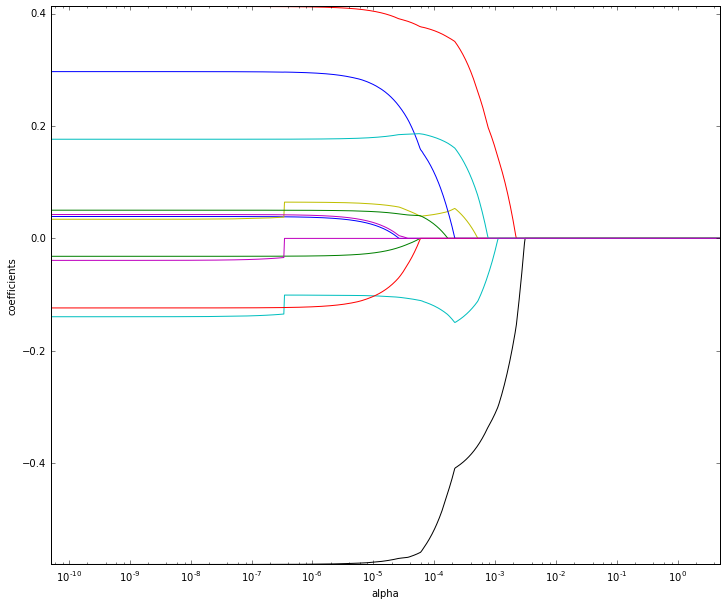

In [289]:
#
# LASSO regression
#

lasso = Lasso(max_iter=10000, normalize=True)
coefs = []
for a in alphas:
    lasso.set_params(alpha=a)
    lasso.fit(scale(X_train), y_train)
    coefs.append(lasso.coef_)
ax = plt.gca()
ax.plot(alphas, coefs)
ax.set_xscale('log')
plt.axis('tight')
plt.xlabel('alpha')
plt.ylabel('coefficients')

In [290]:
# 10-fold cross-validation to select alpha
lassocv = LassoCV(alphas=alphas, cv=10, max_iter=10000, normalize=True)
lassocv.fit(X_train, y_train)
lasso.set_params(alpha=lassocv.alpha_)
lasso.fit(X_train, y_train)
print lasso

Lasso(alpha=5.0000000000000002e-11, copy_X=True, fit_intercept=True,
   max_iter=10000, normalize=True, positive=False, precompute=False,
   random_state=None, selection='cyclic', tol=0.0001, warm_start=False)


In [291]:
MSE_lasso = mean_squared_error(y_test, lasso.predict(X_test))
print ("MSE on test data : %f" % MSE_lasso)

MSE on test data : 0.173881


In [292]:
# R^2 from the best lasso model
r2_lasso = r2_score(y_test, lasso.predict(X_test), sample_weight=None, multioutput=None)
print ("r^2 on test data : %f" % r2_lasso)

r^2 on test data : 0.738873


In [298]:
coef_lasso = pd.Series(lasso.coef_, index=X.columns)
print coef_lasso

PerULPwrlimited          0.001387
RACH_RespRate           -0.001834
MIMO_CQI                 0.172329
AWS                     -0.285791
L700                    -0.079111
PCS                      0.088023
log_PDCCH_Util          -0.649590
log_Max_ConnectedUE      0.227193
log_Blk_Rate             0.133622
log_Data_Vol            -0.192925
sqrt_UL_SINR_forPUCCH    0.153895
sqrt_UL_SINR_forPUSCH    0.033995
dtype: float64


In [300]:
coef_lasso.to_csv("coef_lasso.csv")